In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import scipy as sp
import networkx as nx
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [ ]:
# Create a matrix filled with random numbers of size NxN
def create_matrix(N, sigma=None, random_func=None):
    sigma = np.sqrt(N)/np.pi
    random_func = np.random.randn
    H = sigma * random_func(N,N)
    H[np.diag_indices_from(H)] *= np.sqrt(2)
    indices_trilower = np.tril_indices_from(H)
    H[indices_trilower] = H.T[indices_trilower].conjugate()

    return H

# Calculate the eigenvalues of these matrices and extract the middle m values
def get_center_eigenvalues(H, m):
    eigvals = np.linalg.eigvalsh(H)
    offset = (H.shape[0] -  m) // 2
    return eigvals[offset:offset + m]

# Start with the largest matrix and reduce that in size
def reduce_matrix(H, n=1):
    assert H.shape[0] > n
    return H[:-n, :-n] * np.sqrt((H.shape[0] - n) / H.shape[0])

# Create a sequence of data to 'learn' from
N = 1750
m = 500
D_in = m
N_min = 750

eigenvalues = np.empty((N - N_min, m), dtype=float)
H_full = create_matrix(N)
H = H_full.copy()
for i in tqdm.tqdm(range(eigenvalues.shape[0]), total=eigenvalues.shape[0]):
    eigenvalues[i]= get_center_eigenvalues(H, m)
    H = reduce_matrix(H)

In [5]:
def create_A_tilde(D_r, p, rho):
    rstate = np.random.RandomState(12367548)
    
    # Create the Erdős–Rényi graph and adjacency matrix
    R = nx.erdos_renyi_graph(D_r, p, rstate, directed=True)
    A_tilde = nx.adjacency_matrix(R).astype(float)
    A_tilde.data[:] = rstate.uniform(0, 1, A_tilde.nnz)
    
    # Normalize by the largest eigenvalue
    lambda_max = sp.sparse.linalg.eigs(A_tilde, k=1, which='LM', return_eigenvectors=False)
    A_tilde.data[:] *= rho / np.abs(lambda_max)
    
    return A_tilde

In [6]:
def create_W_in(D_r, sigma):
    rstate = np.random.RandomState(12367548)
    
    # Define the connections
    num_connections = D_r / D_in
    row = np.arange(D_r)
    col = np.repeat(np.arange(D_in), num_connections)
    rstate.shuffle(col)
    
    # Create the W_in matrix
    x = rstate.uniform(-sigma, sigma, D_r)
    W_in = sp.sparse.coo_matrix((x, (row, col)), shape=(D_r, D_in))
    
    return W_in

In [5]:
def eval_loss(params):
    p, rho, sigma, D_r = params
    
    # Create the matrices using the new functions
    A_tilde = create_A_tilde(D_r, p, rho)
    W_in = create_W_in(D_r, sigma)
    
    
    # Initialize the reservoir state 
    r_t = np.ones(D_r)

    # Create matrix U 
    U = eigenvalues.T

    # Reduce matrix U 
    U = U[:, :N_learn - N_min]

    # Initialize the reservoir state matrix
    R = np.zeros((D_r, N_learn - N_min))

    for i in range(U.shape[1]):
        u_t = U[:, i]
        r_t_next = np.tanh(A_tilde @ r_t + W_in @ u_t)
        r_t = r_t_next
        R[:, i] = r_t

    # Create matrix X 
    X = R.copy()
    # Squaring the elements at even indices 
    X[::2, :] *= X[::2, :] 
    
    N_learn = 1750
    losses = []
    N_next = N_learn - 10

    while N_next >= N_min:

        # Update U and X
        U_modified = U[:, :N_next - N_min]
        X_modified = X[:, :N_next - N_min]

        if X_modified.shape[1] == 0:
            break
        
        # Create matrix P 
        beta = 1e-4  
        I = np.eye(D_r)
        P = U_modified @ X_modified.T @ np.linalg.inv(X_modified @ X_modified.T + beta * I)

    # Calculate the loss
        loss = 0
        for i in range(X_modified.shape[1]):

            # Calculate prediction
            prediction = np.dot(P, X_modified[:, i])
            
            term1 = np.linalg.norm(U_modified[:, i] - prediction) ** 2
            term2 = beta * np.linalg.norm(P) ** 2

            # Compute the total loss
            loss += term1 + term2

        losses.append((N_next, loss / X_modified.shape[1]))
        print(f"N_next: {N_next}, Loss: {loss / X_modified.shape[1]}")

        N_next -= 10

    return losses

In [6]:
p_values = [0.05, 0.1, 0.15]
rho_values = [0.5, 0.75, 0.9]
sigma_values = [0.7, 1.0]
D_r_values = [500, 1000, 1500, 2000, 2500]

In [ ]:
results = []

# Calculate loss values
for params in itertools.product(p_values, rho_values, sigma_values, D_r_values):
    p, rho, sigma, D_r = params
    losses = eval_loss(params)
    

    filtered_results = [loss for params, N_next, loss in results]

    filename = f"loss_func_Dr={D_r:06d}_p={p:04.3f}_sigma={sigma:03.2f}_rho={rho:03.2f} for N=1750.png"
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(filtered_results)), filtered_results, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Loss')
    plt.title(f'Loss Function Values for Dr={D_r}, p={p}, sigma={sigma}, rho={rho} for N=1750')
    plt.grid(True)
    plt.savefig(filename)
    plt.close()
    print(f"Created {filename}")

    # Store all results
    for N_next, loss in losses:
        result = (params, N_next, loss)
        results.append(result)

        print(f'Params: {params}, Loss: {losses}')

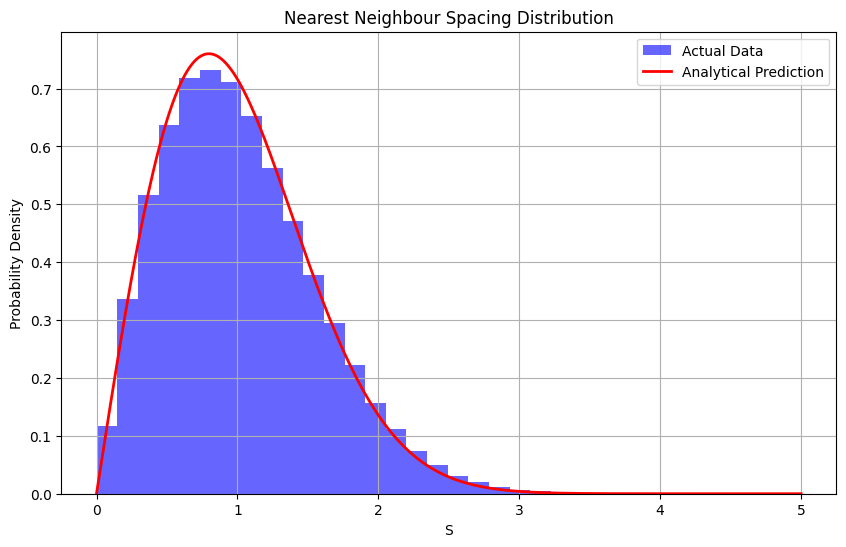

In [12]:
# Calculate the differences between successive eigenvalues
S = np.diff(eigenvalues, axis=1) 

# Flatten the S array to combine all spacings into a single dataset
S_flattened = S.flatten()

# Compute the Wigner Surmise function 
def wigner_surmise(s):
    return (np.pi * s / 2) * np.exp(-np.pi * s**2 / 4)

# Create an array of s values for plotting the Analytical Prediction
s_values = np.linspace(0, 5, 1000)  
p_s_values = wigner_surmise(s_values)

# Plot the histogram of S_m
plt.figure(figsize=(10, 6))
plt.hist(S_flattened, bins=30, density=True, alpha=0.6, color='blue', label="Actual Data")

# Overlay the Wigner Surmise
plt.plot(s_values, p_s_values, color='red', linewidth=2, label="Analytical Prediction")

# Labels and legend
plt.title("Nearest Neighbour Spacing Distribution")
plt.xlabel("S")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

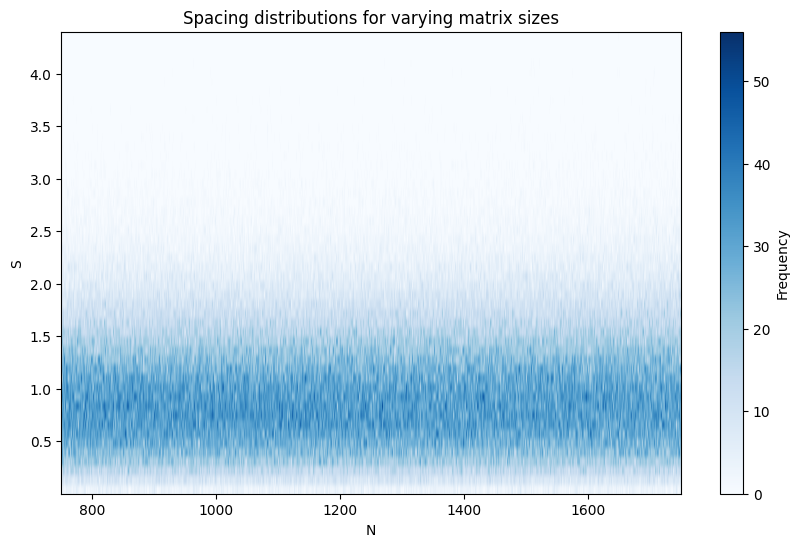

In [13]:
# Plot the spacing distributions for varying matrix sizes
S_min = np.min(S)
S_max = np.max(S)
hist_data = []

for i in range(S.shape[0]):
    hist, bins = np.histogram(S[i], bins=50, range=(S_min, S_max))
    hist_data.append(hist)

hist_data = np.array(hist_data)

# Use imshow to visualize the histogram of S across different N
plt.figure(figsize=(10, 6))
plt.imshow(hist_data.T, aspect='auto', origin='lower', extent=[N_min, N, S_min, S_max], cmap='Blues')
plt.colorbar(label='Frequency')
plt.title("Spacing distributions for varying matrix sizes")
plt.xlabel("N")
plt.ylabel("S")
plt.grid(False)
plt.show()

In [4]:
def create_matrix(N, sigma=None, random_func=None):
    sigma = np.sqrt(N)/np.pi
    random_func = np.random.randn
    H = sigma * random_func(N,N)
    H[np.diag_indices_from(H)] *= np.sqrt(2)
    indices_trilower = np.tril_indices_from(H)
    H[indices_trilower] = H.T[indices_trilower].conjugate()

    return H

# Calculate the eigenvalues of these matrices and extract the middle m values
def get_center_eigenvalues(H, m):
    eigvals = np.linalg.eigvalsh(H)
    offset = (H.shape[0] -  m) // 2
    return eigvals[offset:offset + m]

def reduce_matrix(H, n=1):
    assert H.shape[0] > n
    return H[:-n, :-n] * np.sqrt((H.shape[0] - n) / H.shape[0])

N = 1750
m = 500
D_in = m
N_min = 750

eigenvalues = np.empty((N - N_min, m), dtype=float)
H_full = create_matrix(N)
H = H_full.copy()
for i in tqdm.tqdm(range(eigenvalues.shape[0]), total=eigenvalues.shape[0]):
    eigenvalues[i]= get_center_eigenvalues(H, m)
    H = reduce_matrix(H)

100%|██████████| 1000/1000 [02:08<00:00,  7.75it/s]


In [7]:
# Define parameters
p, rho, sigma, D_r = 0.05, 0.5, 0.7, 1000 
N_learn = 1250

# Create A_tilde and W_in
A_tilde = create_A_tilde(D_r, p, rho)
W_in = create_W_in(D_r, sigma)

# Initialize reservoir state 
r_t = np.ones(D_r)

# Create matrix U 
U = eigenvalues.T

# Reduce matrix U
U_reduced = U[:, :N_learn - N_min]

# Initialize the reservoir state matrix for training
R_train = np.zeros((D_r, N_learn - N_min))

# Training loop
for i in range(U_reduced.shape[1]):
    u_t = U_reduced[:, i]  
    r_t_next = np.tanh(A_tilde @ r_t + W_in @ u_t)
    r_t = r_t_next
    R_train[:, i] = r_t

# Create matrix X_train
X_train = R_train.copy()
# Squaring the elements at even indices 
X_train[::2, :] *= X_train[::2, :] 

# Create matrix P for training
beta = 1e-4  
I = np.eye(D_r)
P = U_reduced @ X_train.T @ np.linalg.inv(X_train @ X_train.T + beta * I)

In [8]:
# Initialize U_pred array for storing predictions
U_pred = []

R_pred = np.zeros((D_r, N - N_learn))

# Prediction loop from N_learn to N
for i in range(N - N_learn):
    u_t = U[:, N_learn - N_min + i]
    r_t_next = np.tanh(A_tilde @ r_t + W_in @ u_t)
    r_t = r_t_next
    R_pred[:, i] = r_t

    # Create X_current from R_pred
    X_current = r_t.copy()
    X_current[::2] *= X_current[::2]

    U_next = P @ X_current
    U_pred.append(U_next)


U_pred = np.array(U_pred)

In [14]:
S_subset = S[500:, :]
S_subset_flattened = S_subset.flatten()

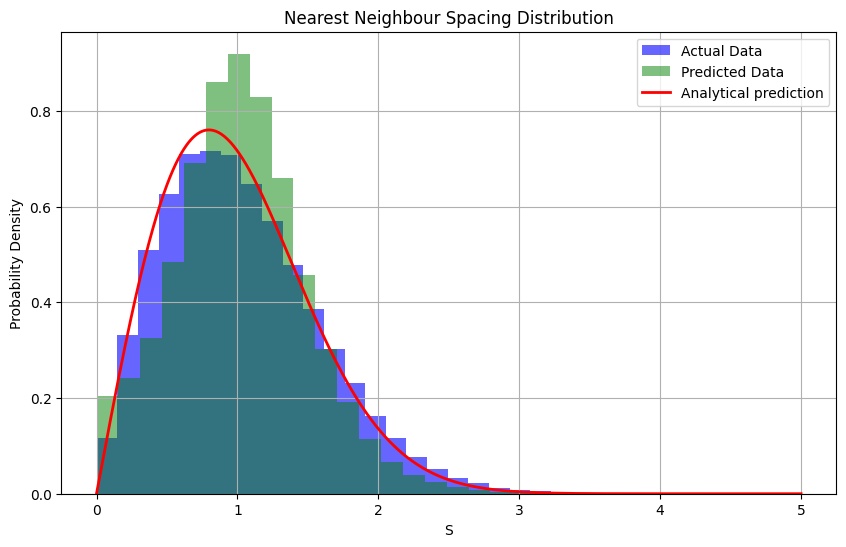

In [15]:
S_pred = np.diff(np.sort(U_pred), axis=1)

# Flatten the S_pred array to combine all spacings into a single dataset
S_pred_flattened = S_pred.flatten()

plt.figure(figsize=(10, 6))

# Plot the histogram of the actual spacings
plt.hist(S_subset_flattened, bins=30, density=True, alpha=0.6, color='blue', label="Actual Data")

# Plot the histogram of the predicted spacings
plt.hist(S_pred_flattened, bins=30, density=True, alpha=0.5, color='green', label="Predicted Data")

# Overlay the Wigner Surmise distribution
plt.plot(s_values, p_s_values, color='red', linewidth=2, label="Analytical prediction")

plt.title("Nearest Neighbour Spacing Distribution")
plt.xlabel("S")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

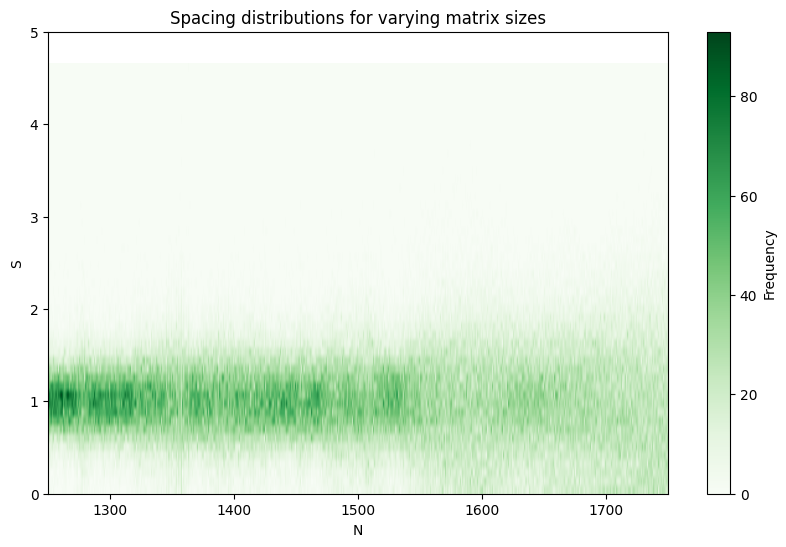

In [16]:
# Plot the spacing distributions for varying matrix sizes
S_pred_min = np.min(S_pred)
S_pred_max = np.max(S_pred)
hist_data_pred = []

for i in range(S_pred.shape[0]):
    hist, bins = np.histogram(S_pred[i], bins=50, range=(S_pred_min, S_pred_max))
    hist_data_pred.append(hist)

hist_data_pred = np.array(hist_data_pred)

# Use imshow to visualize the histogram of S across different N
plt.figure(figsize=(10, 6))

# Set limit for y-axis 
plt.ylim(0,5)

plt.imshow(hist_data_pred.T, aspect='auto', origin='lower', extent=[N_learn, N, S_pred_min, S_pred_max], cmap='Greens')

plt.colorbar(label='Frequency')
plt.title("Spacing distributions for varying matrix sizes")
plt.xlabel("N")
plt.ylabel("S")
plt.grid(False)
plt.show()